En este código pretendo tomar 4 imágenes representativas de cada clase y aumentarlas con las técnicas de TensorFlow. Voy a usar el tf.Image.  

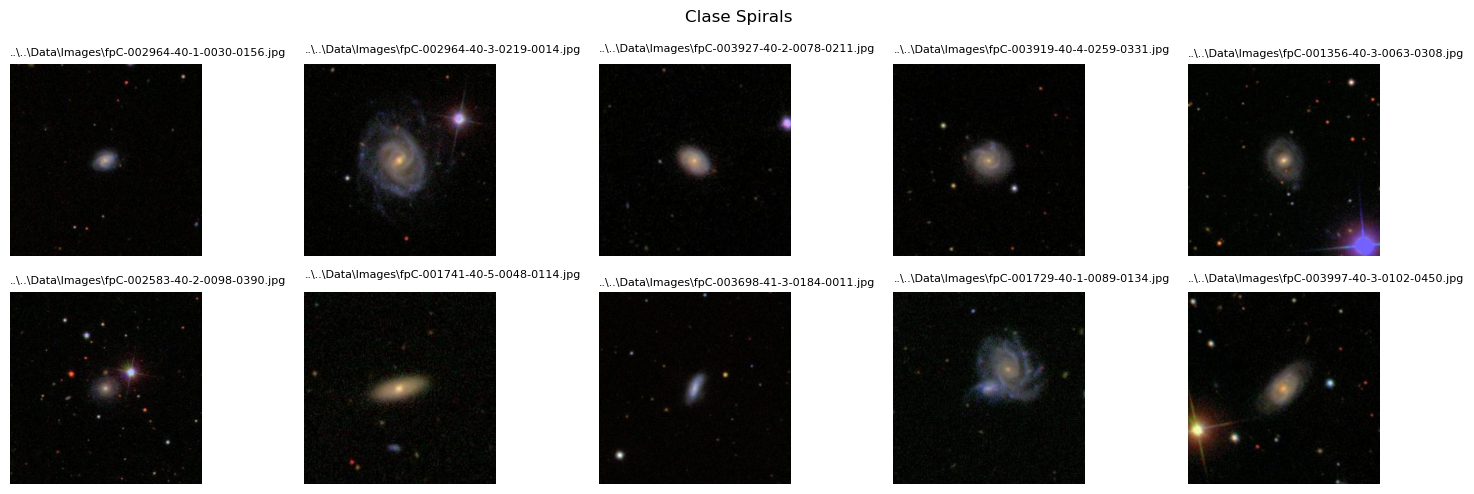

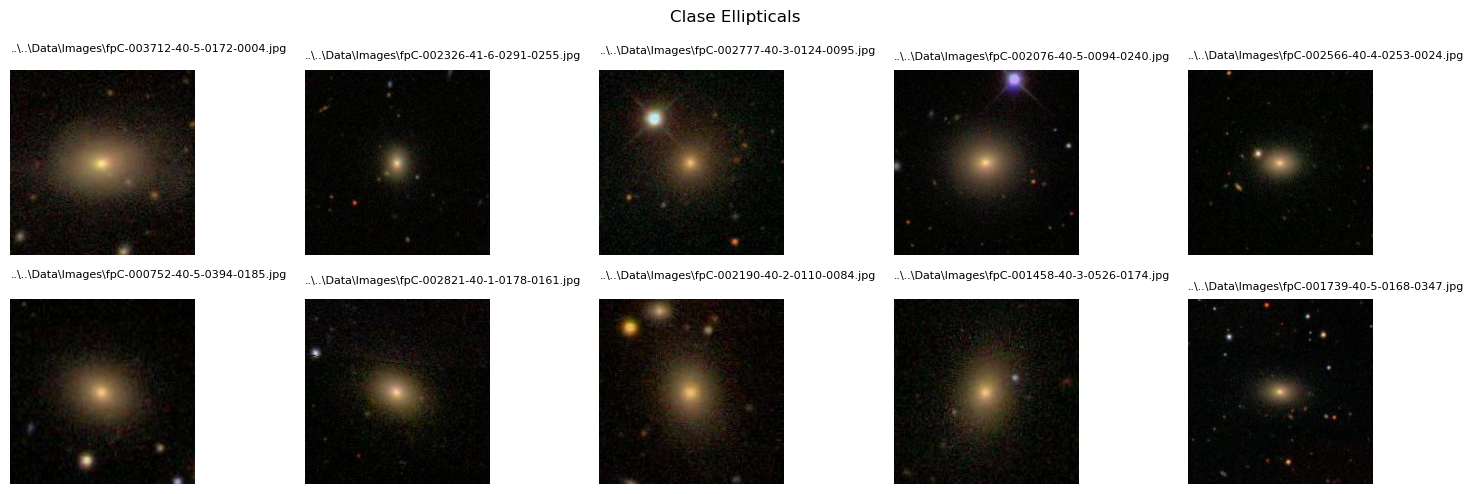

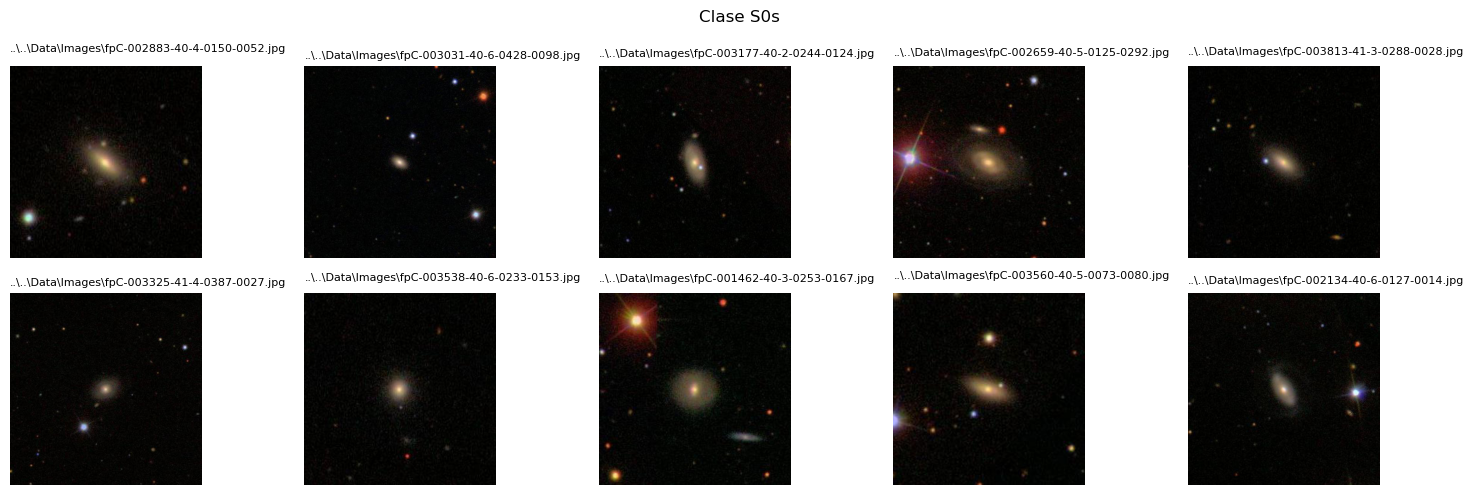

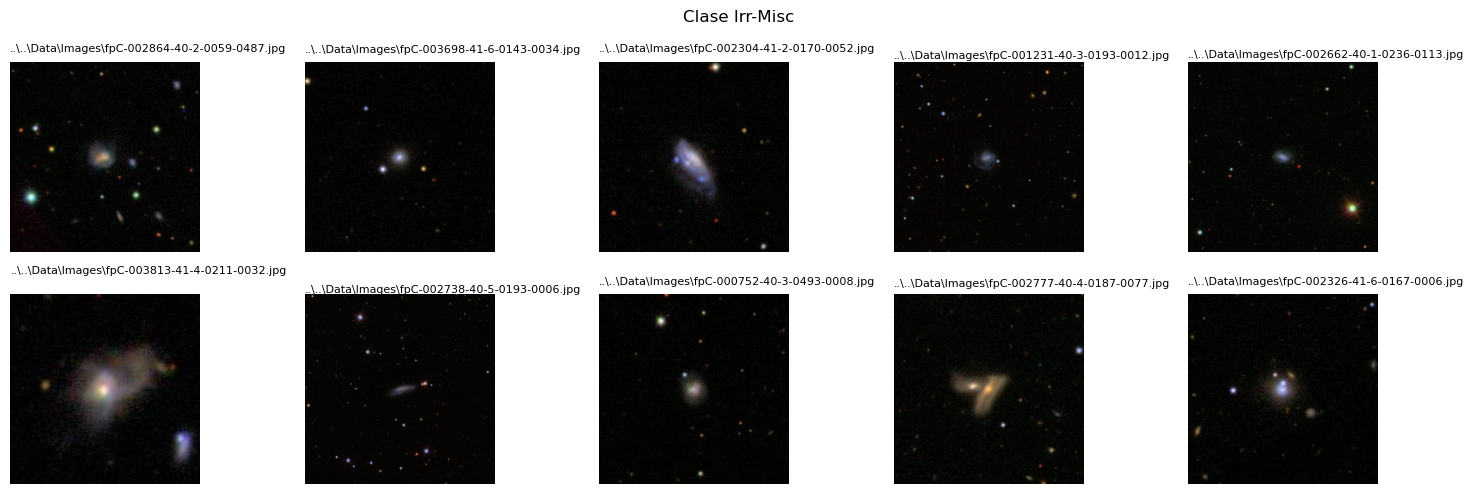

In [42]:
# Voy a tomar las imágenes del csv train. Veámos unas cuantas para ver cuáles son más representativas de cada clase
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Cargar el archivo CSV "train.csv"
train_df = pd.read_csv('C:\\Users\\maseo\\OneDrive\\Escritorio\\GalaxyClassification\\Data\\Dataset\\Val.csv', sep=';')

# Obtener las clases únicas en el conjunto de entrenamiento
clases_unicas = train_df['Clase'].unique()

# Mostrar 10 imágenes por cada clase
for clase in clases_unicas:
    # Seleccionar 10 imágenes aleatorias de la clase actual
    imagenes_clase = train_df[train_df['Clase'] == clase].sample(n=10, random_state=6445)
    
    # Mostrar las imágenes con sus fpCid
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Clase {clase}')
    for i, (_, row) in enumerate(imagenes_clase.iterrows()):
        img = Image.open(row['fpCid'])
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.text(0, -20, row['fpCid'], fontsize=8, ha='left', wrap=True)
    plt.tight_layout()
    plt.show()

In [43]:
# Me quedo con 4 de cada clase

espirales = ('..\\..\\Data\\Images\\fpC-003804-41-2-0120-0093.jpg', '..\\..\\Data\\Images\\fpC-002206-40-1-0079-0128.jpg', '..\\..\\Data\\Images\\fpC-003927-40-4-0012-0258.jpg', '..\\..\\Data\\Images\\fpC-001739-40-3-0070-0290.jpg' )
elipticas = ('..\\..\\Data\\Images\\fpC-003818-41-6-0383-0086.jpg', '..\\..\\Data\\Images\\fpC-003031-40-5-0299-0194.jpg', '..\\..\\Data\\Images\\fpC-003225-40-4-0071-0021.jpg', '..\\..\\Data\\Images\\fpC-001045-40-6-0061-0025.jpg' )
S0s = ('..\\..\\Data\\Images\\fpC-003818-41-3-0195-0004.jpg', '..\\..\\Data\\Images\\fpC-001350-40-3-0168-0169.jpg', '..\\..\\Data\\Images\\fpC-001043-40-6-0115-0133.jpg', '..\\..\\Data\\Images\\fpC-002830-41-4-0249-0005.jpg' )
IrrMisc = ('..\\..\\Data\\Images\\fpC-002738-40-1-0229-0126.jpg', '..\\..\\Data\\Images\\fpC-003712-40-6-0045-0038.jpg', '..\\..\\Data\\Images\\fpC-002304-41-2-0170-0052.jpg', '..\\..\\Data\\Images\\fpC-002777-40-4-0187-0077.jpg' )

En el paper usan tres técnicas:
- Cropping
- Rotation
- Mirroring

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


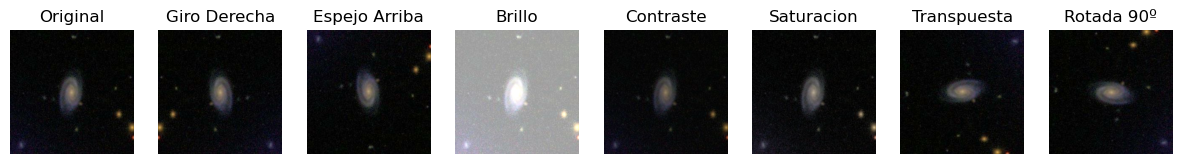

In [44]:
# Esas son las elegidas como representantes de cada clase. Procedo ahora al data augmentation.

import tensorflow as tf

# Función para cargar y preprocesar una imagen desde su path relativo
def cargar_y_preprocesar_imagen(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Función para aplicar técnicas de data augmentation a una imagen
def aplicar_data_augmentation(img):

    # Gira la imagen hacia la derecha
    img_flip_lr = tf.image.flip_left_right(img)

    # Espejo hacia arriba
    img_flip_ud = tf.image.flip_up_down(img)

    # Para el brillo, se le mete un parámetro delta que define el intervalo [-delta, delta] de brillo que aleatoriamente se le aplica a la imagen
    # Delta entre [0, inf]
    img_brightness = tf.image.random_brightness(img, 1)

    # Para rotar en pasos de 90º, se usa tf.image.rot90. k es el factor que indica cuantos giros de 90º se realizan
    img_rot = tf.image.rot90(img, k=1)

    # Para la saturacion, se le meten dos parametros que definen el intervalo [lower, upper] de saturacion que aleatoriamente se le aplica a la imagen
    # [0,inf]
    img_sat = tf.image.random_saturation(img, 0,1)

    # Para el contraste, se le meten dos parametros que definen el intervalo [lower, upper] de contraste que aleatoriamente se le aplica a la imagen
    # [0,inf]
    img_contrast = tf.image.random_contrast(img, 0,1)

    # Transpuesta de la imagen
    img_trans = tf.image.transpose(img)
    
    return [img, img_flip_lr, img_flip_ud, img_brightness, img_contrast, img_sat, img_trans, img_rot]

# Mostrar subplots para cada imagen con distintas técnicas de data augmentation
def mostrar_data_augmentation(path):
    augmented = ('Original', 'Giro Derecha', 'Espejo Arriba', 'Brillo', 'Contraste', 'Saturacion',  'Transpuesta', 'Rotada 90º')
    # Cargar y preprocesar la imagen original
    img_original = cargar_y_preprocesar_imagen(path)
    
    # Aplicar data augmentation a la imagen original
    imagenes_data_augmentation = aplicar_data_augmentation(img_original)

    # Configurar subplots
    fig, axs = plt.subplots(1, len(imagenes_data_augmentation), figsize=(15, 5))
    axs[0].set_title("Original")
    
    # Mostrar cada versión de la imagen en subplots
    for i, img in enumerate(imagenes_data_augmentation):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(augmented[i])

    plt.show()

# Mostrar data augmentation para una imagen de ejemplo
mostrar_data_augmentation(espirales[0])



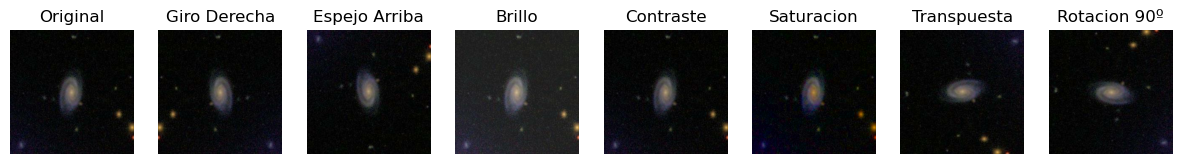

In [45]:
# La celda anterior muestra los resultados aleatoriamente. Yo quiero ver que ocurre con los valores extremos de estos intervalos.
# Básicamente para saber los límites de aplicabilidad de estos data augmentation

# Esas son las elegidas como representantes de cada clase. Procedo ahora al data augmentation.

import tensorflow as tf

# Función para cargar y preprocesar una imagen desde su path relativo
def cargar_y_preprocesar_imagen(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# Función para aplicar técnicas de data augmentation a una imagen
def aplicar_data_augmentation(img):

    # Gira la imagen hacia la derecha
    img_flip_lr = tf.image.flip_left_right(img)

    # Espejo hacia arriba
    img_flip_ud = tf.image.flip_up_down(img)

    # Para el brillo, se le mete un parámetro delta que define el intervalo [-delta, delta] de brillo que aleatoriamente se le aplica a la imagen
    # Delta entre [0, 1]
    img_brightness = tf.image.adjust_brightness(img, 0.105)

    # Para rotar en pasos de 90º, se usa tf.image.rot90. k es el factor que indica cuantos giros de 90º se realizan
    img_rot = tf.image.rot90(img, k=1)

    # Para la saturacion, se le meten dos parametros que definen el intervalo [lower, upper] de saturacion que aleatoriamente se le aplica a la imagen
    img_sat = tf.image.adjust_saturation(img, 2)

    # Para el contraste, se le meten dos parametros que definen el intervalo [lower, upper] de contraste que aleatoriamente se le aplica a la imagen
    img_contrast = tf.image.adjust_contrast(img, 1)

    # Transpuesta de la imagen
    img_trans = tf.image.transpose(img)
    
    return [img, img_flip_lr, img_flip_ud, img_brightness, img_contrast, img_sat, img_trans, img_rot]

# Mostrar subplots para cada imagen con distintas técnicas de data augmentation
def mostrar_data_augmentation(path):
    augmented = ('Original', 'Giro Derecha', 'Espejo Arriba', 'Brillo', 'Contraste', 'Saturacion', 'Transpuesta', 'Rotacion 90º')
    # Cargar y preprocesar la imagen original
    img_original = cargar_y_preprocesar_imagen(path)
    
    # Aplicar data augmentation a la imagen original
    imagenes_data_augmentation = aplicar_data_augmentation(img_original)

    # Configurar subplots
    fig, axs = plt.subplots(1, len(imagenes_data_augmentation), figsize=(15, 5))
    axs[0].set_title("Original")
    
    # Mostrar cada versión de la imagen en subplots
    for i, img in enumerate(imagenes_data_augmentation):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(augmented[i])
        
    plt.show()
    
    

# Mostrar data augmentation para una imagen de ejemplo
mostrar_data_augmentation(espirales[0])


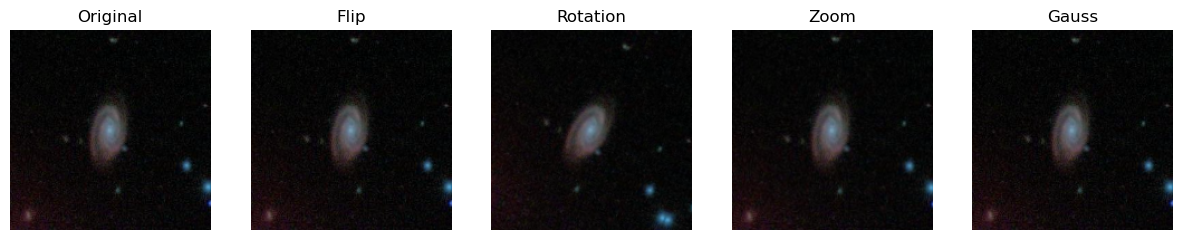

In [120]:
# Esto ha sido con tf.images. Yo realmente quiero hacerlo con layers, de tal forma que en mi modelo de red neuronal, 
# la primera indicación sea el data augmentation y posteriormente las capas.

# Voy a seguir el procedimiento de Manuel

# Creo una lista vacía
X = []

# Le meto estas 4 imágenes al vector X 
for image in espirales:
    # Leo la ruta
    img = cv2.imread(str(image))
    # Reshapeo la foto
    img = cv2.resize(img,(180,180))
    # La añado a X
    X.append(img)

# La paso a np.array
X = np.array(X)

# Lo escalo para que los pixeles estén entre 0 y 1
X = X / 255

flip = tf.keras.Sequential([
     layers.RandomFlip()
  ])
rotation = tf.keras.Sequential([
     layers.RandomRotation(0.1)
  ])
zoom = tf.keras.Sequential([
     layers.RandomZoom(0.1)
  ])

gauss = tf.keras.Sequential([
    layers.GaussianNoise(0.52, seed=728393812)
])

# meto en una lista las imágenes alteradas

images = [X[0], flip(X)[0].numpy().astype("float32"), rotation(X)[0].numpy().astype("float32"), zoom(X)[0].numpy().astype("float32"), gauss(X)[0].numpy().astype("float32")]

fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
axs[0].set_title("Original")

label = ['Original', 'Flip', 'Rotation', 'Zoom', 'Gauss']
# Mostrar cada versión de la imagen en subplots
for i in range(5):
    axs[i].imshow(images[i])
    axs[i].axis('off')
    axs[i].set_title(label[i])
        
plt.show()